<a href="https://colab.research.google.com/github/Loki-33/Stuffs/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal

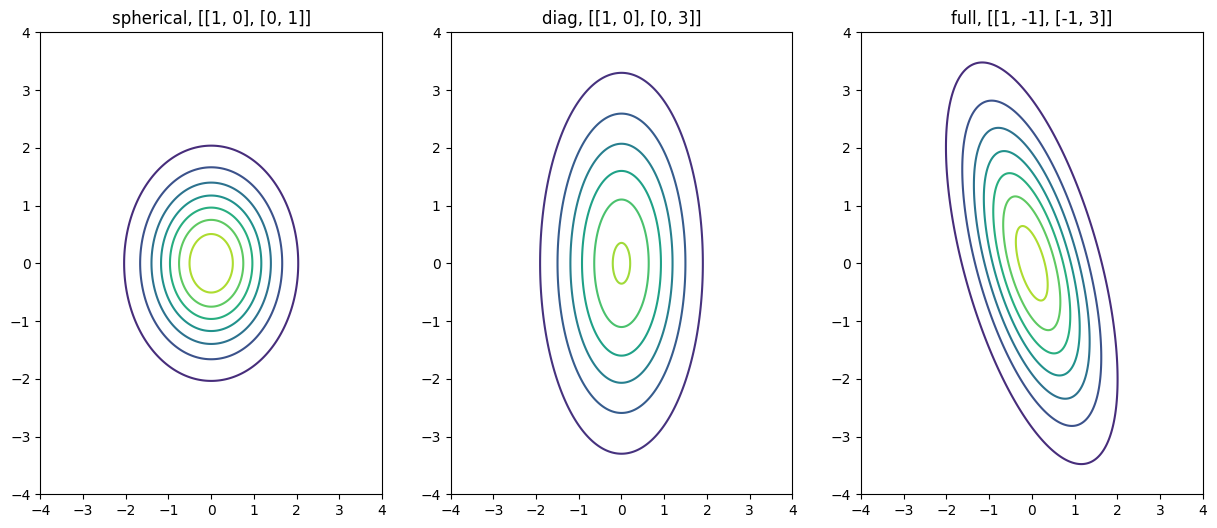

In [ ]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y

covariances = [ [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, -1], [-1, 3]] ]
titles = ['spherical', 'diag', 'full']

plt.figure(figsize = (15, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    z = multivariate_normal([0, 0], covariances[i]).pdf(position)
    plt.contour(x, y, z)
    plt.title('{}, {}'.format(titles[i], covariances[i]))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.show()


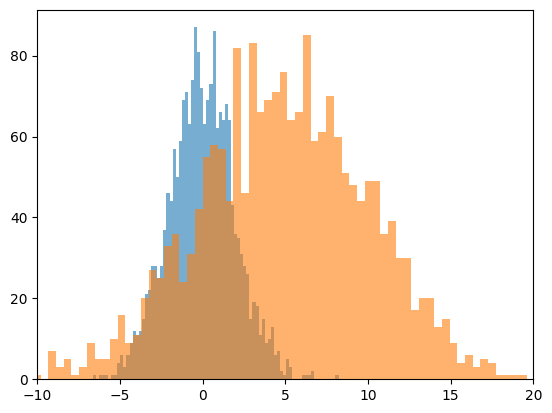

In [ ]:
np.random.seed(2)
x1 = np.random.normal(0, 2, size = 2000)
x2 = np.random.normal(5, 5, size = 2000)
data = [x1, x2]

def plot_hist(data):
    for x in data:
        plt.hist(x, bins = 80, alpha = 0.6)

    plt.xlim(-10, 20)

plot_hist(data)

In [ ]:
def generate_data(n_data, means, covariance, weights):
  n_clusters, n_features = means.shape

  data=np.zeros((n_data, n_features))
  for i in range(n_data):
    k = np.random.choice(n_clusters, size=1, p=weights)[0]
    x = np.random.multivariate_normal(means[k], covariance[k])
    data[i] = x

  return data

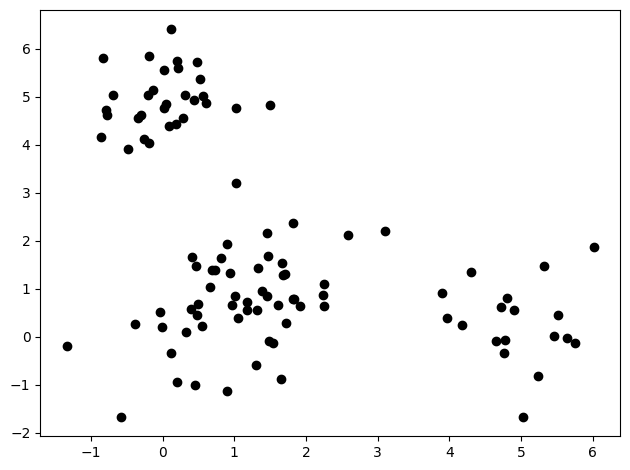

In [ ]:
init_means = np.array([
    [5,0],
    [1,1],
    [0,5]
])
init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])
init_weights = [1 / 4, 1 / 2, 1 / 4]
np.random.seed(4)
X = generate_data(100, init_means, init_covariances, init_weights)
plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()

In [ ]:
class GMM:
  def __init__(self, n_components: int, n_iters: int, tol: float, seed:int):
    self.n_components = n_components
    self.n_iters = n_iters
    self.tol = tol
    self.seed = seed

  def fit(self, X):
    n_row, n_col = X.shape
    self.resp = np.zeros((n_row, self.n_components))

    np.random.seed(self.seed)
    chosen = np.random.choice(n_row, self.n_components, replace=False)
    self.means = X[chosen]
    self.weights = np.full(self.n_components, 1 / self.n_components)

    shape = self.n_components, n_col, n_col
    self.covs = np.full(shape, np.cov(X, rowvar=False))

    log_likelihood = 0
    self.converged = False
    self.log_likelihoods_trace = []

    for i in range(self.n_iters):
      log_likelihood_old = self._do_estep(X)
      self._do_mstep(X)

      if abs(log_likelihood - log_likelihood_old) <= self.tol:
        self.converged = True
        break
      log_likelihood = log_likelihood_old
      self.log_likelihoods_trace.append(log_likelihood)
    return self

  def _do_estep(self, X):
    self._compute_log_likelihood(X)
    log_likelihood = np.sum(np.log(np.sum(self.resp, axis=1)+1e-8))

    return log_likelihood

  def _compute_log_likelihood(self, x):
    for k in range(self.n_components):
      prior = self.weights[k]
      likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
      self.resp[:, k] = prior*likelihood
    return self

  def _do_mstep(self, X):
    resp_weights = self.resp.sum(axis=0)
    self.weights = resp_weights/X.shape[0]

    weighted_sum = np.dot(self.resp.T, X)
    self.means = weighted_sum/resp_weights.reshape(-1,1)

    for k in range(self.n_components):
      diff = (X - self.means[k]).T
      weighted_sum = np.dot(self.resp[:, k]*diff, diff.T)
      self.covs[k] = weighted_sum/resp_weights[k]
      # Add a small regularization term to the covariance matrix
      self.covs[k] += np.eye(self.covs[k].shape[0]) * 1e-6
    return self

In [ ]:
def plot_contours(data, means, covs, title):
  plt.figure()
  plt.plot(data[:, 0], data[:, 1], 'ko')

  delta = 0.025
  k = means.shape[0]
  x=np.arange(-2.0, 7.0, delta)
  y=np.arange(-2.0, 7.0, delta)
  x_grid, y_grid = np.meshgrid(x, y)
  coordinates = np.array([x_grid.ravel(), y_grid.ravel()])

  col = ['green', 'red', 'indigo']
  for i in range(k):
    mean = means[i]
    cov = covs[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates.T).reshape(x_grid.shape)
    plt.contour(x_grid, y_grid, z_grid, colors=col[i])
  plt.title(title)
  plt.tight_layout()

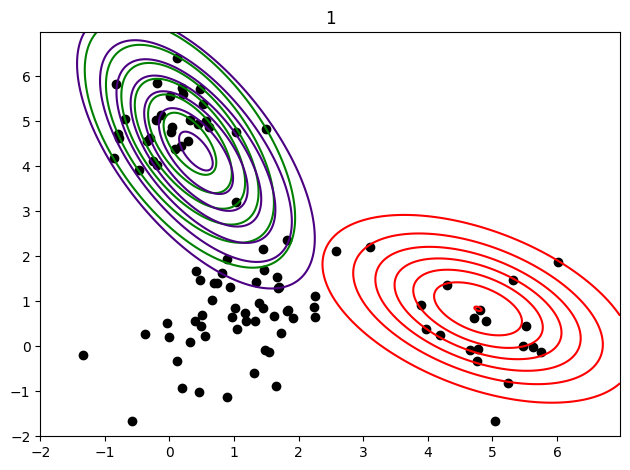

In [ ]:
gmm = GMM(n_components = 3, n_iters = 1, tol = 1e-4, seed = 4)
gmm.fit(X)

plot_contours(X, gmm.means, gmm.covs, '1')


converged iteration: 13


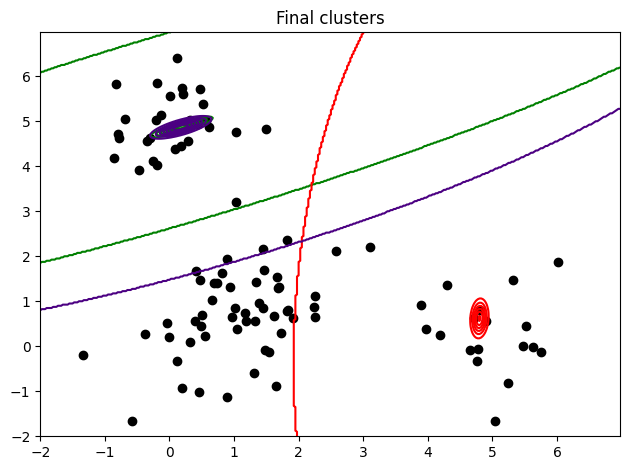

In [ ]:
gmm = GMM(n_components = 3, n_iters = 50, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihoods_trace))
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')

converged or not:  True


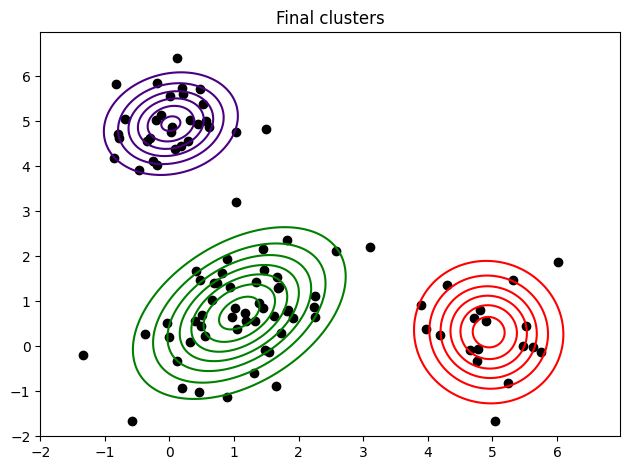

In [ ]:
gmm = GaussianMixture(n_components = 3, covariance_type = 'full',
                      max_iter = 600, random_state = 3)
gmm.fit(X)

print('converged or not: ', gmm.converged_)
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')
